This notebook tests whether we can load the Mie fitting model and use it to do stuff

In [125]:
import pickle
import math
import numpy as np
from scipy.special import jv, yv, jve, yve
import matplotlib.pyplot as plt
import pandas as pd
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold, train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
import tensorflow as tf
import csv
import sys
import mie_data_generator_function as mdg

In [126]:
model = load_model("Mie_model_v2de la soul")

How do we work out whether it loaded? I could load the test data and see if that could be predicted...first maybe try to load Rhys's data? I saved it as a pickle...lets try it:

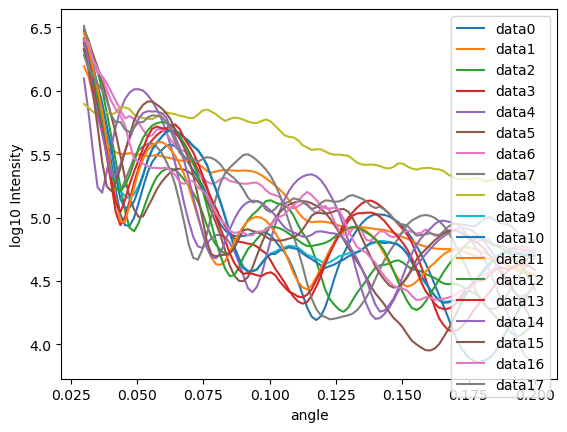

In [127]:
#root = '/Users/sam/Documents/Nano-Mei'
root = '/Users/wsb/Library/CloudStorage/OneDrive-SharedLibraries-UniversityofSouthampton/Phase retrieval with neural nets - Documents/nanoparticle Mie scattering project/mie Python code/wsb working'

ints = np.zeros([18,100], dtype ="float")
angles = np.zeros([18,100], dtype ="float")

with open("{}/rhys_intensities.txt".format(root), "r") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    # Load the data from the file
    line_count = 0
    for row in csv_reader:
        
        #print(len(row))
        ints[line_count,:] = row[:] 
        line_count+=1

with open("{}/rhys_angles.txt".format(root), "r") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    # Load the data from the file
    line_count = 0
    for row in csv_reader:
        angles[line_count,:] = row[:] 
        line_count+=1

#max_log_I = 10  # this is setting the number I'm scaling to
for ii in range(ints.shape[0]):
    foo = ints[ii,:]
    #ints[ii,:] = max_log_I * foo/foo[0]
    ints[ii,:] = foo + 2.2  #shifting everything up by 2.2 as a by-hand scaling

#check teh data form...

fig, ax = plt.subplots()
#ax.plot(angles2,log_np_I[ii,:], label='training data')
for jj in range(18):
    ax.plot(angles[jj,:], ints[jj,:], label='data{}'.format(jj))
#ax[1].plot(angles[jj,:], ints[jj,:])
    ax.legend(loc='upper right')
    ax.set_xlabel('angle')
    ax.set_ylabel('log10 Intensity')

plt.show()

Now I have to wrangle the arrays into the right sizes to run the test. Let's go back to the training program to see how everything is formatted...turns out it's already the right format! OK, let's go!

In [128]:
y_pred = model.predict(ints)

1/1 [==============================] - 0s 36ms/step


2023-03-03 16:55:29.440519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [129]:
#let's see one...hold on, how?
#need to remove the scaling here...Using teh KNOWN values from the data generator.
index_min = 1.3
index_max = 1.8
radius_min = 6
radius_max = 14
y_unscaled = np.zeros(y_pred.shape)
y_unscaled[:,0] = (y_pred[:,0]*(index_max-index_min))+index_min
y_unscaled[:,1] = (y_pred[:,0]*(radius_max-radius_min))+radius_min
print(y_pred)
print(y_unscaled)

[[ 0.21149296  0.2879667 ]
 [ 0.20513272  0.5952946 ]
 [ 0.5334346   0.2297349 ]
 [ 0.20075613  0.46387783]
 [ 0.20555604  0.60257286]
 [ 0.14841497  0.18944922]
 [ 0.597418    0.6243512 ]
 [ 0.20344436  0.3151787 ]
 [-0.1624738   0.7578044 ]
 [ 0.41244394  0.4484172 ]
 [ 0.3964462   0.3960461 ]
 [ 0.23575103  0.33822945]
 [ 0.40202612  0.5733918 ]
 [ 0.34263968  0.483836  ]
 [ 0.4801757   0.45755786]
 [ 0.38482332  0.49535877]
 [ 0.3783131   0.5323085 ]
 [ 0.15988544  0.7259541 ]]
[[ 1.40574646  7.69194365]
 [ 1.40256631  7.64106178]
 [ 1.56671727 10.26747704]
 [ 1.40037799  7.60604906]
 [ 1.40277791  7.64444828]
 [ 1.3742075   7.18731976]
 [ 1.59870899 10.77934456]
 [ 1.40172219  7.62755489]
 [ 1.21876311  4.70020962]
 [ 1.50622189  9.29955101]
 [ 1.49822307  9.17156982]
 [ 1.41787553  7.88600826]
 [ 1.50101304  9.21620941]
 [ 1.47131979  8.74111748]
 [ 1.54008782  9.84140587]
 [ 1.49241161  9.07858658]
 [ 1.48915648  9.02650452]
 [ 1.37994266  7.27908325]]


So at the moment, all the values are sort of scrambled, all the indices and radii are outside of the range of the training data. I haven't done anything about the saling, though, so that might be all over the place. Need to examine the traing data to see how the scaling is....OK, the scaling is supposedly fixed, but now I really need to compare the simulated data for the parameters the model has returned. That means taking the found parameters and running them through the Mie data simulator (or picking out the particular simulated data corresponding to these values.)

Might have to have the mie data generator runing as  a function somehow...need to learn how...seems OK - added in the first block

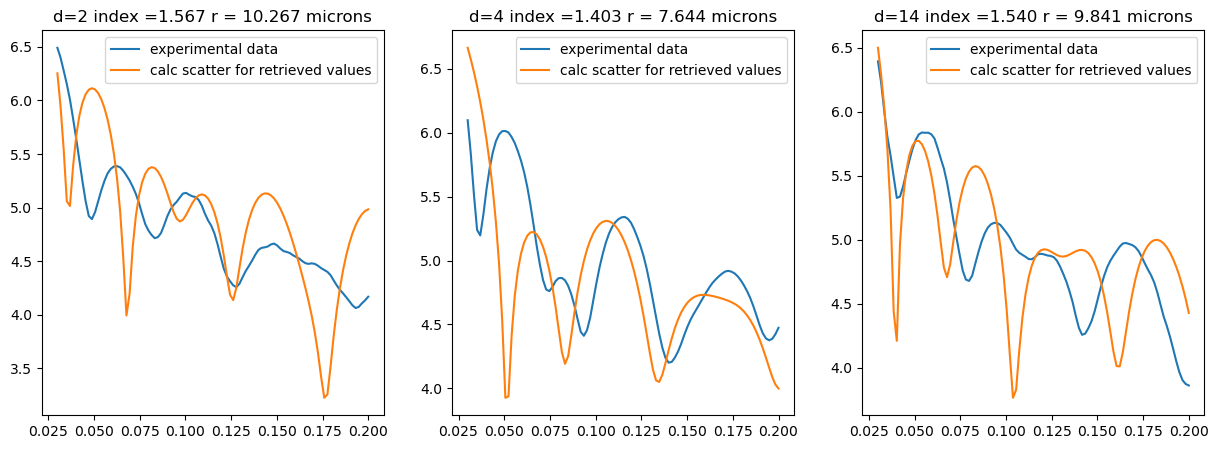

In [130]:

#d = [0,2,3,4,5,7,9,10,11,13,14,15]  # the dataset to compare
d = [2,4,14]
fig, ax = plt.subplots(1,len(d), figsize=(15,5))
#set up the angles corresponding to the model data
theta_start = 0.03
theta_end = 0.2
th_steps = 100
theta = np.linspace(theta_start, theta_end, th_steps)
#set up the indices
background_index = 1
lambda_ = 632.8646e-9  #HeNe wavelength
for i in range(0, len(d)):
    #theta, Icalc = mdg.generate_data(y_pred[d[i],0], 1e-6*y_pred[d[i],1])
    #Icalc = mdg.mie_theta(lambda_,theta.reshape(1,th_steps) , 1e-5*y_pred[d[i],1], background_index, y_pred[d[i],0] )
    Icalc = mdg.mie_theta(lambda_,theta.reshape(1,th_steps) , 1e-6*y_unscaled[d[i],1], background_index, y_unscaled[d[i],0] )
    Icalc = np.log10(Icalc)
    #Icalc = Icalc + (10-Icalc[0])
    #ax[i].figure()
    ax[i].plot(angles[d[i],:], ints[d[i],:], label='experimental data')
    ax[i].plot(theta, Icalc,label='calc scatter for retrieved values')
    ax[i].legend(loc='upper right')
    #title_str  = 'index =%g r = %g microns' % (y_pred[d,0],y_pred[d,1])
    ax[i].set_title('d={} index ={:.3f} r = {:.3f} microns'.format(d[i],y_unscaled[d[i],0],y_unscaled[d[i],1]))  
plt.show()